In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.python.keras.utils.generic_utils import get_custom_objects
%matplotlib inline
plt.rcParams.update({'font.size': 14})

# load saved model (just using CNN for brevity)

In [8]:
# need to define custom activation function before saved model can be lladed
def sigmoid_scaled(x, lower=0.21, upper=0.59):
    scale = upper - lower
    return scale * tf.nn.sigmoid(x) + lower

get_custom_objects().update({'sigmoid_scaled': sigmoid_scaled})


model = keras.models.load_model('model_CNN.h5', custom_objects={'sigmoid_scaled': sigmoid_scaled})

# read and plot seismic data

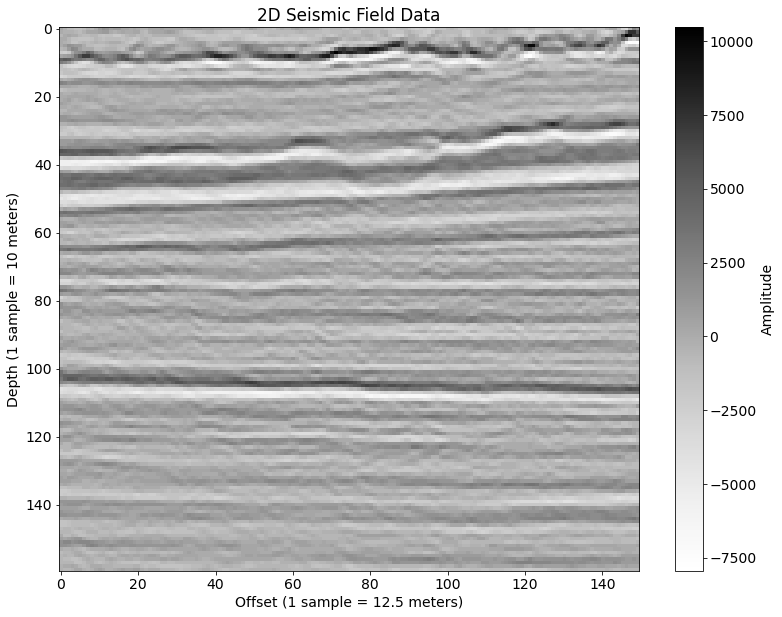

In [9]:
seismic = np.load('real_2d_seismic_Draupne.npy')
seismic = seismic[:,:150]

fig,ax = plt.subplots(figsize=(13,10))
im = ax.imshow(seismic, aspect='auto', cmap='Greys')
ax.set_ylabel('Depth (1 sample = 10 meters)')
ax.set_xlabel('Offset (1 sample = 12.5 meters)')
ax.set_title('2D Seismic Field Data')
plt.colorbar(im, label='Amplitude')
#fig.savefig('seismic_2d_data.jpg', dpi=1000, bbox_inches='tight')

# Extract traces at different offset locations, predict on them

In [10]:
# load synthetic example of appoximate brittleness 0.33
synth_ex = np.load('synth_example_for_field_compare.npy')

# 3 traces, 101 samples each
field_traces = np.zeros((3,101))
field_pred = np.zeros(3)

# predict on traces at offsets 10, 35, and 75
for count,offset in zip(range(3), [10, 35, 75]):
    
    # extract 101 long trace around the Draupne formation caprock
    trace = seismic[:, offset][14:115]
    
    # zero out the amplitudes above and below it
    trace[:45] = 0
    trace[65:] = 0
    
    # reshape trace for use in network
    trace = np.reshape(trace, (1, 101))
    
    # normalize trace with minmax like in training data
    trace_normed = trace/np.max(trace)
    
    # make brittleness prediction
    ypred = model.predict(trace_normed)
    
    # save field traces and predictions
    field_traces[count, :] = trace
    field_pred[count] = ypred
    

1/1 [==============================] - 0s 16ms/step


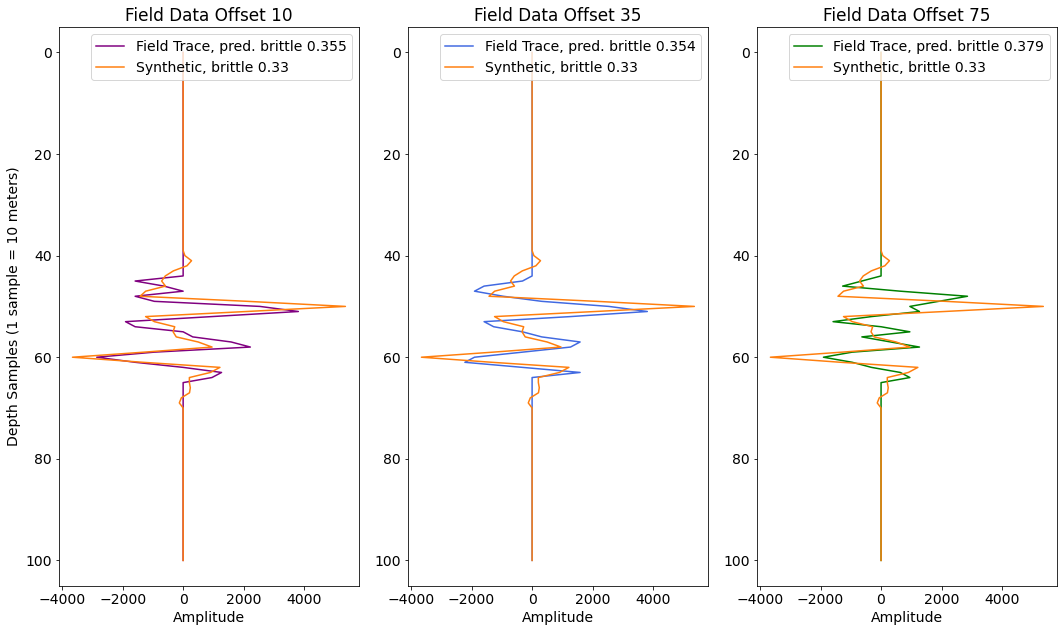

In [11]:
fig,ax = plt.subplots(1, 3, figsize=(15,9))
ax[0].plot(field_traces[0,:], range(101), label='Field Trace, pred. brittle '+str(round(field_pred[0],3)), color='purple')
ax[0].plot(synth_ex, range(101), label='Synthetic, brittle 0.33', color='#ff7f0e')
ax[0].invert_yaxis()
ax[0].legend()
ax[0].set_xlabel('Amplitude')
ax[0].set_ylabel('Depth Samples (1 sample = 10 meters)')
ax[0].set_title('Field Data Offset 10')
#ax[0].set_xlim(-2800, 4500)

ax[1].plot(field_traces[1,:], range(101), label='Field Trace, pred. brittle '+str(round(field_pred[1],3)), color='royalblue')
ax[1].plot(synth_ex, range(101), label='Synthetic, brittle 0.33', color='#ff7f0e')
ax[1].invert_yaxis()
ax[1].legend()
ax[1].set_xlabel('Amplitude')
#ax[1].set_ylabel('Depth Samples (1 sample = 10 meters)')
ax[1].set_title('Field Data Offset 35')
#ax[1].set_xlim(-2800, 4500)

ax[2].plot(field_traces[2,:], range(101), label='Field Trace, pred. brittle '+str(round(field_pred[2],3)), color='green')
ax[2].plot(synth_ex, range(101), label='Synthetic, brittle 0.33', color='#ff7f0e')
ax[2].invert_yaxis()
ax[2].legend()
ax[2].set_xlabel('Amplitude')
#ax[2].set_ylabel('Depth Samples (1 sample = 10 meters)')
ax[2].set_title('Field Data Offset 75')
#ax[2].set_xlim(-2800, 4500)

plt.tight_layout()
#fig.savefig('field_data_results.jpg', dpi=1000, bbox_inches='tight')